#Deep Learning sobre dados meteorológicos tabulares: Baseline


Segunda etapa do projeto elaborado na disciplina MO434 - Deep Learning (2s2020)

Matheus de Souza Ataide/147375

Mauricio de Sousa Araujo/184477

Raysa Masson Benatti/176483

Para rodar o código, é necessário fazer upload do arquivo ``esalq.XLS``.

O arquivo pode ser acessado [aqui](http://www.leb.esalq.usp.br/leb/postocon.html) ("Valores Absolutos"), devendo ser renomeado para ``esalq.XLS``. 

O relatório que detalha o experimento pode ser lido [aqui](https://www.overleaf.com/read/mjrvxrpmrqsp).

##Bibliotecas

In [ ]:
import pandas as pd 
import numpy as np
from numpy import array
from matplotlib import pyplot as plt
import matplotlib as mpl

##Get and Preprocess Data 

In [ ]:
#Leitura e Preprocessamento
esalq = pd.read_excel("esalq.XLS", skiprows=19)
#extraimos so as 3 primeiras colunas, que nos interessam: ano, tmin e tmax
esalq = esalq.iloc[:,[0,1,2]]
#renomeamos colunas
esalq.rename(columns={esalq.columns[0]: "ano", esalq.columns[1]: "tmax", esalq.columns[2]: "tmin"}, inplace = True)

#preprocessamento: extrair somente dados brutos de tmax e tmin mes a mes, pra todos os anos
#excluir linhas de gap e reorganizar as linhas
#para tanto, extraimos os dados mes a mes e os concatenamos depois

#no dataset original, a organizacao seguida eh:

# repete 12x (1x para cada mes)
#   HEADER
#   linha gap
#   linha gap
#   1917
#   1918
#   ...
#   2019
#   2020 (exceto para dezembro)
#   14 linhas gap

months = ["jan", "fev", "mar", "abr", "mai", "jun", "jul", "ago", "set", "out", "nov", "dez"]
init = 2
end = 106

data = pd.DataFrame()

for month in months:
  esalq_month = esalq.iloc[init:end]
  esalq_month = esalq_month.copy()
  init+= 121
  if month != "nov": #dezembro nao tem registros em 2020
    end+= 121
  else:
    end+= 120

  #renomeamos cada "ano" para "ano-mes"
  for index, row in esalq_month.iterrows():
    esalq_month.loc[index, "ano"] = str(row[0])+"-"+month
  
  #concatenar
  data = data.append(esalq_month, ignore_index=True)

#conversao de tipos
data = data.astype({"tmax": float, "tmin": float}, errors="ignore")

#reordenando linhas para ficarem em ordem cronologica 
tags = []
start=0
step=12
stop=(104*step)
for j in range(12):
    for i in range(start, stop, step):
        tags.append(i)
    start=start+1
    stop=stop+1
tags.pop() #deleta ultimo indice, ja que pra 2020 ha 11 elementos e nao 12

data["tag"] = tags
data.sort_values(by="tag", axis=0, inplace=True, ignore_index=True)
data.drop(columns=["tag"], inplace=True)
data.tail()

,ano,tmax,tmin
1242,2020-jul,31.1,5.0
1243,2020-ago,33.9,7.4
1244,2020-set,39.8,12.8
1245,2020-out,41.2,12.9
1246,2020-nov,36.9,11.8


##Split Data


In [ ]:
#dividindo os dados em treino, validacao e teste na proporcao 70:20:10

column_indices = {name: i for i, name in enumerate(data.columns)}

n = len(data)
train_df = data[0:int(n*0.7)]
val_df = data[int(n*0.7):int(n*0.9)]
test_df = data[int(n*0.9):]

num_features = data.shape[1]
print(f'{len(train_df)} dados para treino')
print(f'{len(val_df)} dados para validação')
print(f'{len(test_df)} dados para teste')

872 dados para treino
250 dados para validação
125 dados para teste


##Window generator

In [ ]:
# univariate data preparation
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
  X = []
  y = []
  #, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
		# gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)
 
# define input sequence
raw_seq = train_df["tmax"]
# choose a number of time steps
n_steps = 10
# split into samples
X_train, y_train = split_sequence(train_df["tmax"].values, n_steps)
X_val, y_val = split_sequence(val_df["tmax"].values, n_steps)
X_test, y_test = split_sequence(test_df["tmax"].values, n_steps)

# summarize the data
print(f'Windows de tamanho {X_train.shape[1]} e {X_train.shape[0]} dados gerados para treino')
print(f'Windows de tamanho {X_val.shape[1]} e {X_val.shape[0]} dados gerados para validação')
print(f'Windows de tamanho {X_test.shape[1]} e {X_test.shape[0]} dados gerados para teste')
 
 

Windows de tamanho 10 e 862 dados gerados para treino
Windows de tamanho 10 e 240 dados gerados para validação
Windows de tamanho 10 e 115 dados gerados para teste


In [ ]:
#removemos linhas que possuem valores NaN
def remove_nan(X, Y):
  ok = []
  for i in range(len(X)):
    if np.isnan(Y[i]) or np.isnan(np.sum(X[i])):
      ok += [False]
    else:
      ok += [True]
  ok = np.array(ok)
  return X[ok], Y[ok]


#demonstracao de janelas
X, y = remove_nan(X_train, y_train)
for i in range(len(X)):
	print(X[i], y[i])

[30.8 32.2 33.5 30.  29.  27.2 28.8 31.  34.5 34.2] 36.6
[32.2 33.5 30.  29.  27.2 28.8 31.  34.5 34.2 36.6] 36.0
[33.5 30.  29.  27.2 28.8 31.  34.5 34.2 36.6 36. ] 34.4
[30.  29.  27.2 28.8 31.  34.5 34.2 36.6 36.  34.4] 33.2
[29.  27.2 28.8 31.  34.5 34.2 36.6 36.  34.4 33.2] 32.6
[27.2 28.8 31.  34.5 34.2 36.6 36.  34.4 33.2 32.6] 32.0
[28.8 31.  34.5 34.2 36.6 36.  34.4 33.2 32.6 32. ] 30.0
[31.  34.5 34.2 36.6 36.  34.4 33.2 32.6 32.  30. ] 30.0
[34.5 34.2 36.6 36.  34.4 33.2 32.6 32.  30.  30. ] 29.0
[34.2 36.6 36.  34.4 33.2 32.6 32.  30.  30.  29. ] 31.5
[36.6 36.  34.4 33.2 32.6 32.  30.  30.  29.  31.5] 34.0
[36.  34.4 33.2 32.6 32.  30.  30.  29.  31.5 34. ] 33.1
[34.4 33.2 32.6 32.  30.  30.  29.  31.5 34.  33.1] 35.0
[33.2 32.6 32.  30.  30.  29.  31.5 34.  33.1 35. ] 33.2
[32.6 32.  30.  30.  29.  31.5 34.  33.1 35.  33.2] 33.5
[32.  30.  30.  29.  31.5 34.  33.1 35.  33.2 33.5] 35.4
[30.  30.  29.  31.5 34.  33.1 35.  33.2 33.5 35.4] 33.8
[30.  29.  31.5 34.  33.1 35.  

##Vanilla LSTM model 1

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense

#vanilla lstm
n_features = 1 # por enquanto, testamos com so 1 variavel
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
X = X.reshape((X.shape[0], X.shape[1], n_features))
# fit model
epochs=200
history=model.fit(X, y, epochs=epochs, validation_data=(X_val.reshape(X_val.shape[0], X_val.shape[1], n_features), y_val),verbose=1)

Epoch 1/200
25/25 [==============================] - 0s 14ms/step - loss: 1192.5145 - val_loss: 211.6752
Epoch 2/200
25/25 [==============================] - 0s 5ms/step - loss: 40.7914 - val_loss: 9.5276
Epoch 3/200
25/25 [==============================] - 0s 6ms/step - loss: 6.6626 - val_loss: 5.9570
Epoch 4/200
25/25 [==============================] - 0s 6ms/step - loss: 5.0506 - val_loss: 4.9977
Epoch 5/200
25/25 [==============================] - 0s 6ms/step - loss: 4.3515 - val_loss: 4.3365
Epoch 6/200
25/25 [==============================] - 0s 6ms/step - loss: 4.0488 - val_loss: 4.6977
Epoch 7/200
25/25 [==============================] - 0s 6ms/step - loss: 3.8488 - val_loss: 4.0180
Epoch 8/200
25/25 [==============================] - 0s 6ms/step - loss: 3.8025 - val_loss: 3.7438
Epoch 9/200
25/25 [==============================] - 0s 6ms/step - loss: 3.4895 - val_loss: 3.4611
Epoch 10/200
25/25 [==============================] - 0s 6ms/step - loss: 3.4982 - val_loss: 3.6272
Ep

In [ ]:
def plot_history(history, data_time=200, gen_data_time=False,no_key=["title"],figure_size=(10,8)):
    mpl.rcParams['figure.figsize'] = figure_size
    if(gen_data_time):
      data_time = np.arange(data_time) 
    fig, ax = plt.subplots()
    for key in history.keys():
      if(not key in no_key):
        x, y = data_time, history[key]
        ax.plot(x, y,  label=key)
    legend = ax.legend(loc='best')
    ax.set_title(history.get("title"))
    plt.show()

###Loss

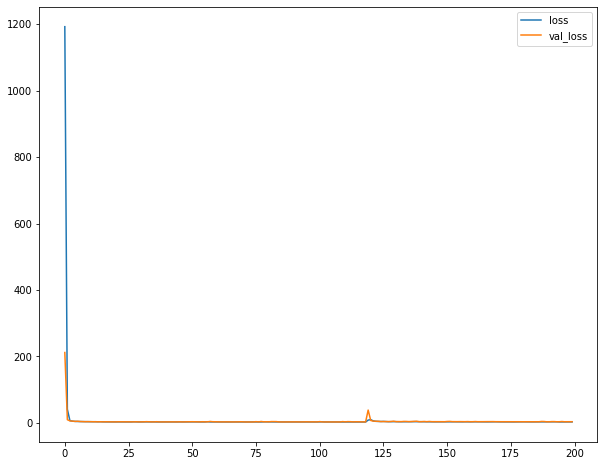

In [ ]:
plot_history(history= history.history, data_time=epochs, gen_data_time=True)

###Predição para validação 

In [ ]:
history_val ={"predict":[],"real": y_val,"title":"Conjunto de validação"}
for i in range(len(X_val)):
  x_input=X_val[i].reshape((1, n_steps, n_features))
  history_val["predict"].append(model.predict(x_input)[0][0])


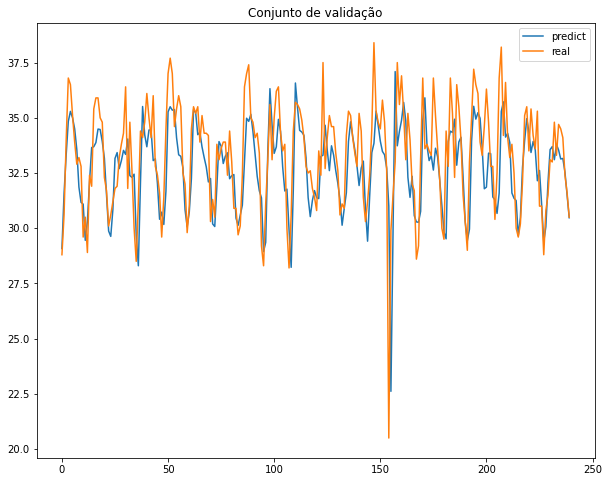

In [ ]:
plot_history(history= history_val, data_time=len(history_val["predict"]), gen_data_time=True)


##Vanilla LSTM model 2

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense

#vanilla lstm
n_features = 1 # por enquanto, testamos com so 1 variavel
# define model2
model2 = Sequential()
model2.add(LSTM(15, activation='relu', input_shape=(n_steps, n_features)))

model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse')

In [ ]:
epochs=200
history=model2.fit(X, y, epochs=epochs, validation_data=(X_val.reshape(X_val.shape[0], X_val.shape[1], n_features), y_val),verbose=1)

Epoch 1/200
25/25 [==============================] - 0s 11ms/step - loss: 656.6671 - val_loss: 161.3493
Epoch 2/200
25/25 [==============================] - 0s 6ms/step - loss: 43.3938 - val_loss: 6.8769
Epoch 3/200
25/25 [==============================] - 0s 5ms/step - loss: 5.1614 - val_loss: 4.0308
Epoch 4/200
25/25 [==============================] - 0s 4ms/step - loss: 3.7561 - val_loss: 3.8075
Epoch 5/200
25/25 [==============================] - 0s 4ms/step - loss: 3.6399 - val_loss: 3.7641
Epoch 6/200
25/25 [==============================] - 0s 4ms/step - loss: 3.6147 - val_loss: 3.6828
Epoch 7/200
25/25 [==============================] - 0s 5ms/step - loss: 3.5418 - val_loss: 3.6342
Epoch 8/200
25/25 [==============================] - 0s 4ms/step - loss: 3.4037 - val_loss: 3.4660
Epoch 9/200
25/25 [==============================] - 0s 4ms/step - loss: 3.2882 - val_loss: 3.4435
Epoch 10/200
25/25 [==============================] - 0s 5ms/step - loss: 3.2237 - val_loss: 3.4381
Epo

###Loss

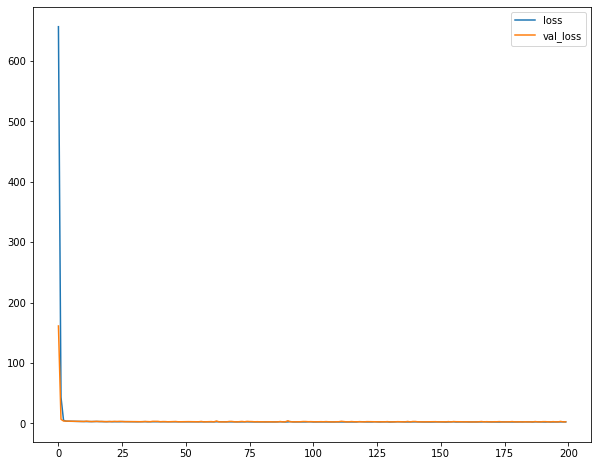

In [ ]:
plot_history(history= history.history, data_time=epochs, gen_data_time=True)

###Predição para validação e teste

In [ ]:
history_val ={"predict":[],"real": y_val,"title":"Conjunto de validação"}
history_test ={"predict":[],"real": y_test,"title":"Conjunto de Teste"}

for i in range(len(X_val)):
  x_input=X_val[i].reshape((1, n_steps, n_features))
  history_val["predict"].append(model2.predict(x_input)[0][0])

for i in range(len(X_test)):
  x_input=X_test[i].reshape((1, n_steps, n_features))
  history_test["predict"].append(model2.predict(x_input)[0][0])

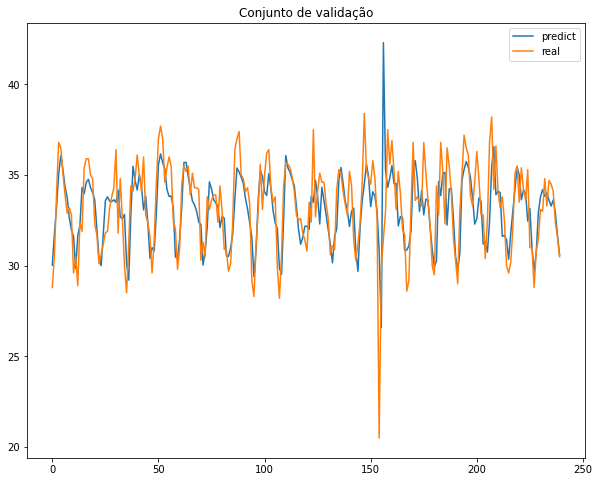

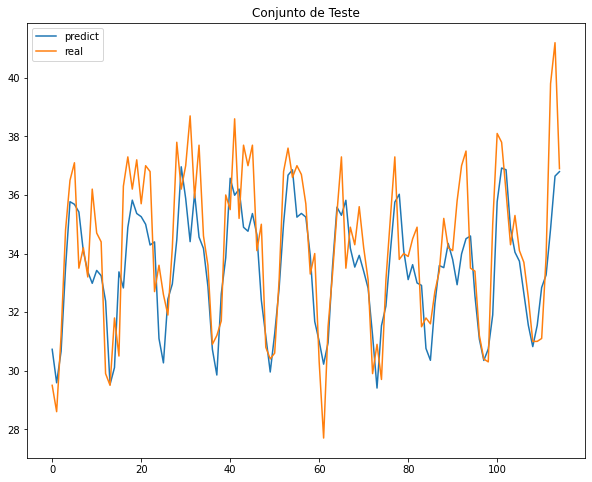

In [ ]:
plot_history(history= history_val, data_time=len(history_val["predict"]), gen_data_time=True)
plot_history(history= history_test, data_time=len(history_test["predict"]), gen_data_time=True)

In [ ]:
# para testar se precisar
# data.to_csv("teste.csv")
# from google.colab import files
# files.download('teste.csv')